In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc
from locscale.utils.map_quality import map_quality_pdb



In [2]:
from sklearn.metrics import recall_score, precision_score 


def get_recall(mf_locscale_map, confidence_map):
    locscale_threshold = 0.1
    emmernet_threshold = 0.3
    

    confidence_map_binarised = (confidence_map >= 0.99).astype(np.int_)

    recall_metrics = {}
    mf_locscale_binarised = (mf_locscale_map >= locscale_threshold).astype(np.int_)
    
    # try:
    #     reported_threshold = deposited_threshold_dict[str(int(emdb))]
    #     # import precision, recall, f1_score from sklearn
    #     deposited_map, apix = load_map(deposited_map)
    #     deposited_map_binarised = (deposited_map >= reported_threshold).astype(np.int_)
    #     deposit_recall = recall_score(confidence_map_binarised.flatten(), deposited_map_binarised.flatten(), average="binary")
    # except KeyError:
    #     print("No threshold for this map")
    #     deposit_recall = 0
    
    # compute the precision, recall, f1_score for the locscale map
    mf_locscale_recall = recall_score(confidence_map_binarised.flatten(), mf_locscale_binarised.flatten(), average="binary")
    return mf_locscale_recall


In [3]:
from locscale.include.emmer.ndimage.profile_tools import frequency_array
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.pdb.pdb_utils import set_atomic_bfactors
import gemmi
from scipy.stats import kurtosis

output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/feature_enhance_test_maps_hybrid_fulldataset_200k"
atomic_model_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/deposited_atomic_models"
model_mask_dir = "/home/abharadwaj1/dev/data/atomic_model_mask"
confidence_mask_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks"
pseudomodel_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/locscale_MF_version_C"
hybrid_locscale_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/hybrid_locscale_maps"
model_based_locscale_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/model_based_locscale_maps"

quality_metrics_all = {}

def get_quality_metrics(emdb_pdb):
    emdb, pdb = emdb_pdb.split("_")
    
    emdb_pdb_dir = os.path.join(output_dir, emdb_pdb)
    
    mf_locscale_path = os.path.join(emdb_pdb_dir, f"emd_{emdb}_emmernet_output_locscale_output.mrc")
    
    pseudomodel_locscale_path = os.path.join(pseudomodel_dir, emdb_pdb, f"emd_{emdb}_model_free_locscale_C.mrc")
    hybrid_locscale_path = os.path.join(hybrid_locscale_dir, f"emd_{emdb}_hybrid_locscale_C.mrc")
    model_based_locscale_path = os.path.join(model_based_locscale_dir, f"emd_{emdb}_model_based_locscale_C.mrc")
    unsharpened_map_path = os.path.join(emdb_pdb_dir, f"EMD_{int(emdb)}_unsharpened_fullmap.mrc")
    confidence_map_path = os.path.join(confidence_mask_dir, f"emd_{emdb}_FDR_confidence_final.map")
    
    atomic_model_mask_path = os.path.join(model_mask_dir, f"atomic_model_mask_{emdb_pdb}.mrc")
    atomic_model_path = os.path.join(atomic_model_dir, f"PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")
    
    if not os.path.exists(atomic_model_mask_path) or not os.path.exists(atomic_model_path) \
        or not os.path.exists(confidence_map_path) or not os.path.exists(unsharpened_map_path) \
        or not os.path.exists(mf_locscale_path) or not os.path.exists(pseudomodel_locscale_path) \
        or not os.path.exists(hybrid_locscale_path) or not os.path.exists(model_based_locscale_path):
        print("Missing files")
        return None
    
    rscc_unsharp= map_quality_pdb(unsharpened_map_path, atomic_model_mask_path, atomic_model_path, test="rscc")
    rscc_locscale = map_quality_pdb(mf_locscale_path, atomic_model_mask_path, atomic_model_path, test="rscc")
    rscc_pseudomodel_locscale = map_quality_pdb(pseudomodel_locscale_path, atomic_model_mask_path, atomic_model_path, test="rscc")
    rscc_hybrid_locscale = map_quality_pdb(hybrid_locscale_path, atomic_model_mask_path, atomic_model_path, test="rscc")
    rscc_model_based_locscale = map_quality_pdb(model_based_locscale_path, atomic_model_mask_path, atomic_model_path, test="rscc")
        
    mf_locscale, apix = load_map(mf_locscale_path)
    unsharpened_map, _ = load_map(unsharpened_map_path)
    atomic_mask, _ = load_map(atomic_model_mask_path)
    confidence_map, _ = load_map(confidence_map_path)
    pseudomodel_locscale, _ = load_map(pseudomodel_locscale_path)
    hybrid_locscale, _ = load_map(hybrid_locscale_path)
    model_based_locscale, _ = load_map(model_based_locscale_path)
    
    st = gemmi.read_structure(atomic_model_path)
    
    st_0 = set_atomic_bfactors(input_gemmi_st=st, b_iso = 10)
    
    simmap_0 = pdb2map(st_0, apix=apix, size=mf_locscale.shape)
    
    smooth_modelmap = atomic_mask * simmap_0
    smooth_mf_locscale = atomic_mask * mf_locscale
    smooth_unsharpened_map = atomic_mask * unsharpened_map
    smooth_pseudomodel_locscale = atomic_mask * pseudomodel_locscale
    smooth_hybrid_locscale = atomic_mask * hybrid_locscale
    smooth_model_based_locscale = atomic_mask * model_based_locscale
    
    fsc_unsharp = calculate_fsc_maps(smooth_unsharpened_map, smooth_modelmap)
    fsc_locscale = calculate_fsc_maps(smooth_mf_locscale, smooth_modelmap)
    fsc_pseudomodel_locscale = calculate_fsc_maps(smooth_pseudomodel_locscale, smooth_modelmap)
    fsc_hybrid_locscale = calculate_fsc_maps(smooth_hybrid_locscale, smooth_modelmap)
    fsc_model_based_locscale = calculate_fsc_maps(smooth_model_based_locscale, smooth_modelmap)
    
    # calculate map kurtosis
    kurtosis_unsharp = kurtosis(smooth_unsharpened_map[atomic_mask == 0.5])
    kurtosis_locscale = kurtosis(smooth_mf_locscale[atomic_mask == 0.5])
    kurtosis_pseudomodel_locscale = kurtosis(smooth_pseudomodel_locscale[atomic_mask == 0.5])
    kurtois_hybrid_locscale = kurtosis(smooth_hybrid_locscale[atomic_mask == 0.5])
    kurtosis_model_based_locscale = kurtosis(smooth_model_based_locscale[atomic_mask == 0.5])
    
    
    recall_locscale = get_recall(mf_locscale, confidence_map)
    recall_pseudomodel_locscale = get_recall(pseudomodel_locscale, confidence_map)
    recall_hybrid_locscale = get_recall(hybrid_locscale, confidence_map)
    recall_model_based_locscale = get_recall(model_based_locscale, confidence_map)
    
    result = {
        "emdb_pdb":emdb_pdb,
        "rscc_unsharp":rscc_unsharp,
        "rscc_locscale":rscc_locscale,
        "rscc_pseudomodel_locscale":rscc_pseudomodel_locscale,
        "rscc_hybrid_locscale":rscc_hybrid_locscale,
        "rscc_model_based_locscale":rscc_model_based_locscale,
        "fsc_unsharp":fsc_unsharp,
        "fsc_locscale":fsc_locscale,
        "fsc_pseudomodel_locscale":fsc_pseudomodel_locscale,
        "fsc_hybrid_locscale":fsc_hybrid_locscale,
        "fsc_model_based_locscale":fsc_model_based_locscale,
        "recall_locscale":recall_locscale,
        "recall_pseudomodel_locscale":recall_pseudomodel_locscale,
        "recall_hybrid_locscale":recall_hybrid_locscale,
        "recall_model_based_locscale":recall_model_based_locscale,
        "kurtosis_unsharp":kurtosis_unsharp,
        "kurtosis_locscale":kurtosis_locscale,
        "kurtosis_pseudomodel_locscale":kurtosis_pseudomodel_locscale,
        "kurtois_hybrid_locscale":kurtois_hybrid_locscale,
        "kurtosis_model_based_locscale":kurtosis_model_based_locscale
    }
    
    
    
    return result

In [4]:

# def add_kurtosis_to_result(result):
#     emdb_pdb = result["emdb_pdb"]
#     emdb, pdb = emdb_pdb.split("_")
    
#     emdb_pdb_dir = os.path.join(output_dir, emdb_pdb)
    
#     mf_locscale_path = os.path.join(emdb_pdb_dir, f"emd_{emdb}_emmernet_output_locscale_output.mrc")
    
#     pseudomodel_locscale_path = os.path.join(pseudomodel_dir, emdb_pdb, f"emd_{emdb}_model_free_locscale_C.mrc")
#     unsharpened_map_path = os.path.join(emdb_pdb_dir, f"EMD_{int(emdb)}_unsharpened_fullmap.mrc")
#     confidence_map_path = os.path.join(confidence_mask_dir, f"emd_{emdb}_FDR_confidence_final.map")
    
#     atomic_model_mask_path = os.path.join(model_mask_dir, f"atomic_model_mask_{emdb_pdb}.mrc")
#     atomic_model_path = os.path.join(atomic_model_dir, f"PDB_{pdb}_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")
    
#     if not os.path.exists(atomic_model_mask_path) or not os.path.exists(atomic_model_path) \
#         or not os.path.exists(confidence_map_path) or not os.path.exists(unsharpened_map_path) \
#         or not os.path.exists(mf_locscale_path) or not os.path.exists(pseudomodel_locscale_path):
#         print("Missing files")
#         return None
    
    
#     mf_locscale, apix = load_map(mf_locscale_path)
#     unsharpened_map, _ = load_map(unsharpened_map_path)
#     atomic_mask, _ = load_map(atomic_model_mask_path)
#     confidence_map, _ = load_map(confidence_map_path)
#     pseudomodel_locscale, _ = load_map(pseudomodel_locscale_path)
    
#     smooth_mf_locscale = atomic_mask * mf_locscale
#     smooth_unsharpened_map = atomic_mask * unsharpened_map
#     smooth_pseudomodel_locscale = atomic_mask * pseudomodel_locscale
    
#     # calculate map kurtosis
#     kurtosis_unsharp = kurtosis(smooth_unsharpened_map.flatten())
#     kurtosis_locscale = kurtosis(smooth_mf_locscale.flatten())
#     kurtosis_pseudomodel_locscale = kurtosis(smooth_pseudomodel_locscale.flatten())
    
#     result["kurtosis_unsharp"] = kurtosis_unsharp
#     result["kurtosis_locscale"] = kurtosis_locscale
#     result["kurtosis_pseudomodel_locscale"] = kurtosis_pseudomodel_locscale
    
#     return result

In [4]:
# use joblib to parallelize the process
from joblib import Parallel, delayed
from tqdm import tqdm
import os 
# all_results = Parallel(n_jobs=14, verbose=10)(delayed(get_quality_metrics)(emdb_pdb) for emdb_pdb in tqdm(os.listdir(output_dir)))

# quality_metrics_all = {all_result["emdb_pdb"]:all_result for all_result in all_results if all_result is not None}

In [5]:
# dump the results to a pickle file
import pickle
output_file_path = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/quality_measures/quality_measures_new_200k.pkl"
#with open(output_file_path, "wb") as f:
#    pickle.dump(quality_metrics_all, f)

# load the results from the pickle file
quality_metrics_all = pickle.load(open(output_file_path, "rb"))

Text(0, 0.5, 'RSCC')

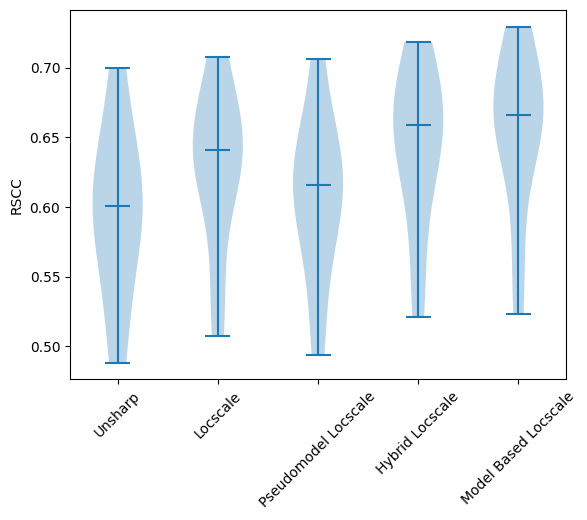

In [6]:
# plot rscc metrics between unsharp and locscale
rscc_unsharp = []
rscc_locscale = []
rscc_pseudomodel_locscale = []
rscc_hybrid_locscale = []
rscc_model_based_locscale = []
for emdb_pdb in quality_metrics_all:
    rscc_unsharp.append(quality_metrics_all[emdb_pdb]["rscc_unsharp"])
    rscc_locscale.append(quality_metrics_all[emdb_pdb]["rscc_locscale"])
    rscc_hybrid_locscale.append(quality_metrics_all[emdb_pdb]["rscc_hybrid_locscale"])
    rscc_model_based_locscale.append(quality_metrics_all[emdb_pdb]["rscc_model_based_locscale"])
    rscc_pseudomodel_locscale.append(quality_metrics_all[emdb_pdb]["rscc_pseudomodel_locscale"])
    
plt.violinplot([rscc_unsharp, rscc_locscale, rscc_pseudomodel_locscale, rscc_hybrid_locscale, rscc_model_based_locscale], showmedians=True)
plt.xticks([1,2,3,4,5], ["Unsharp", "Locscale", "Pseudomodel Locscale", "Hybrid Locscale", "Model Based Locscale"])
# rotate the xticks
plt.xticks(rotation=45)
plt.ylabel("RSCC")



In [7]:
def pretty_violinplots(list_of_series, xticks, ylabel,xlabel=None, figsize_cm=(14,8),\
                        fontscale=3,font="Helvetica",linewidth=2):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import matplotlib as mpl
    ## Function not generic
    mpl.rcParams['pdf.fonttype'] = 42
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
    fig, ax = plt.subplots(figsize=figsize, dpi=600)
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")
    
    sns.violinplot(data=list_of_series, scale_hue=False, ax=ax)
    sns.swarmplot(data=list_of_series, color="black", size=2, ax=ax)
    # highlight the median values in the violin plots
    for i, series in enumerate(list_of_series):
        median = np.median(series)
        ax.plot([i-0.25, i+0.25], [median, median], color="white", linewidth=linewidth)
    
    ax.set_xticklabels(xticks)
    ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    plt.tight_layout()
    return fig

In [9]:
list_of_series = [rscc_unsharp, rscc_locscale, rscc_pseudomodel_locscale, rscc_hybrid_locscale, rscc_model_based_locscale]
xticks = ["U", "MF", "P-MF", "H", "MB"]
ylabel = "RSCC"
kwargs = {"figsize_cm":(6,4), "fontscale":0.5, "font":"Helvetica", "linewidth":1}

fig_rscc = pretty_violinplots(list_of_series, xticks, ylabel, **kwargs)
# increase ylim 
fig_rscc.axes[0].set_ylim(0.3, 0.85)
# save the figure
figsavepath = os.path.join(os.path.dirname(output_file_path), "rscc_violinplot_newMF.eps")
#fig_rscc.savefig(figsavepath, bbox_inches="tight")




/home/abharadwaj1/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Kurtosis')

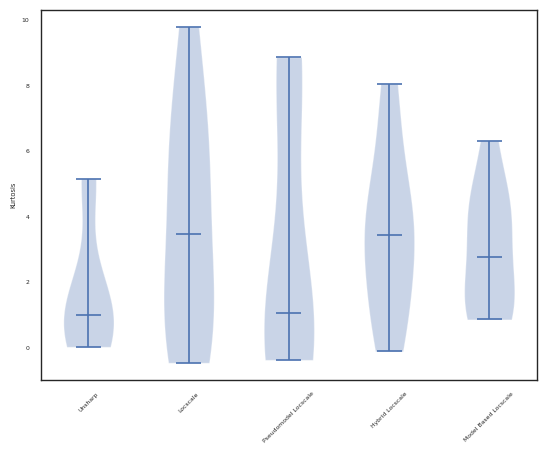

In [10]:
# plot kurtosis metrics between unsharp and locscale
kurtosis_unsharp = []
kurtosis_locscale = []
kurtosis_pseudomodel_locscale = []
kurtosis_hybrid_locscale = []
kurtosis_model_based_locscale = []

for emdb_pdb in quality_metrics_all:
    kurtosis_unsharp.append(quality_metrics_all[emdb_pdb]["kurtosis_unsharp"])
    kurtosis_locscale.append(quality_metrics_all[emdb_pdb]["kurtosis_locscale"])
    kurtosis_pseudomodel_locscale.append(quality_metrics_all[emdb_pdb]["kurtosis_pseudomodel_locscale"])
    kurtosis_hybrid_locscale.append(quality_metrics_all[emdb_pdb]["kurtois_hybrid_locscale"])
    kurtosis_model_based_locscale.append(quality_metrics_all[emdb_pdb]["kurtosis_model_based_locscale"])

plt.violinplot([kurtosis_unsharp, kurtosis_locscale, kurtosis_pseudomodel_locscale, kurtosis_hybrid_locscale, kurtosis_model_based_locscale], showmedians=True)
plt.xticks([1,2,3,4,5], ["Unsharp", "Locscale", "Pseudomodel Locscale", "Hybrid Locscale", "Model Based Locscale"])
# rotate the xticks
plt.xticks(rotation=45)
plt.ylabel("Kurtosis")



In [11]:
def pretty_boxplots(list_of_series, xticks, ylabel,xlabel=None, figsize_cm=(14,8),\
                        fontscale=3,font="Helvetica",linewidth=2):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import matplotlib as mpl
    ## Function not generic
    mpl.rcParams['pdf.fonttype'] = 42
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
    fig, ax = plt.subplots(figsize=figsize, dpi=600)
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")
    
    sns.boxplot(data=list_of_series, ax=ax)
    sns.swarmplot(data=list_of_series, color="black", size=2, ax=ax)
    # highlight the median values in the violin plots
    for i, series in enumerate(list_of_series):
        median = np.median(series)
        ax.plot([i-0.25, i+0.25], [median, median], color="white", linewidth=linewidth)
    
    ax.set_xticklabels(xticks)
    ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    plt.tight_layout()
    return fig

/home/abharadwaj1/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


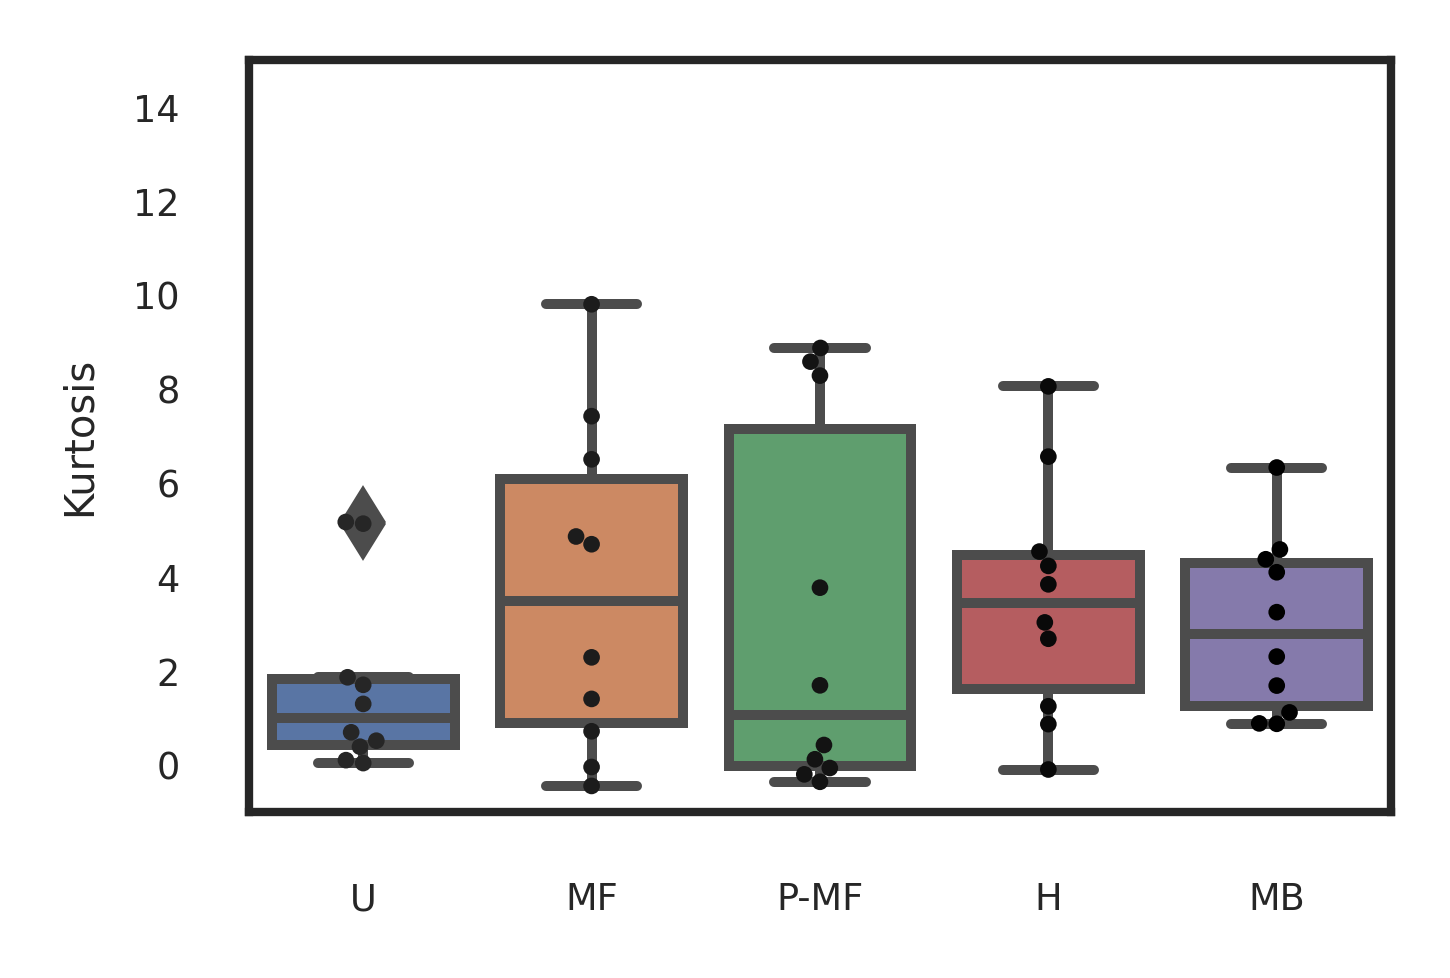

In [12]:
list_of_kurtosis_series = [kurtosis_unsharp, kurtosis_locscale, kurtosis_pseudomodel_locscale, kurtosis_hybrid_locscale, kurtosis_model_based_locscale]
xticks = ["U", "MF", "P-MF", "H", "MB"]
ylabel = "Kurtosis"
kwargs = {"figsize_cm":(6,4), "fontscale":0.5, "font":"Helvetica", "linewidth":1}
fig_kurtosis = pretty_boxplots(list_of_kurtosis_series, xticks, ylabel, **kwargs)
# increase ylim
fig_kurtosis.axes[0].set_ylim(-1, 15)
figsavepath_kurt = os.path.join(os.path.dirname(output_file_path), "kurtosis_boxplot_newMF.eps")
fig_kurtosis.savefig(figsavepath_kurt, bbox_inches="tight")

In [13]:
# plot the recall metrics between locscale methods
recall_locscale = []
recall_pseudomodel_locscale = []
recall_hybrid_locscale = []
recall_model_based_locscale = []

for emdb_pdb in quality_metrics_all:
    recall_locscale.append(quality_metrics_all[emdb_pdb]["recall_locscale"])
    recall_pseudomodel_locscale.append(quality_metrics_all[emdb_pdb]["recall_pseudomodel_locscale"])
    recall_hybrid_locscale.append(quality_metrics_all[emdb_pdb]["recall_hybrid_locscale"])
    recall_model_based_locscale.append(quality_metrics_all[emdb_pdb]["recall_model_based_locscale"])
    
plt.violinplot([recall_locscale, recall_pseudomodel_locscale, recall_hybrid_locscale, recall_model_based_locscale], showmedians=True)
plt.xticks([1,2,3,4], ["Locscale", "Pseudomodel Locscale", "Hybrid Locscale", "Model Based Locscale"])
# rotate the xticks
plt.xticks(rotation=45)
plt.ylabel("Recall")


Text(0, 0.5, 'Recall')

In [18]:
from scipy.stats import permutation_test
np.random.seed(0)
# Perform permutation test to compare the distributions
print("=============================================")
print("Permutation test")
print("=============================================")
print("Distribution: RSCC ")

def statistic(x,y):
    return np.median(x) - np.median(y)

def permutation_test_wrapper(x,y):
    return permutation_test((x, y), statistic=statistic, n_resamples=10000)

permut_mf_locscale = permutation_test_wrapper(rscc_unsharp, rscc_locscale)
permut_pseudomodel_locscale = permutation_test_wrapper(rscc_unsharp, rscc_pseudomodel_locscale)
permut_hybrid_locscale = permutation_test_wrapper(rscc_unsharp, rscc_hybrid_locscale)
permut_model_based_locscale = permutation_test_wrapper(rscc_unsharp, rscc_model_based_locscale)

print("=============================================")
print("Model Free LocScale", permut_mf_locscale.pvalue)
print("Pseudomodel LocScale", permut_pseudomodel_locscale.pvalue)
print("Hybrid LocScale", permut_hybrid_locscale.pvalue)
print("Model Based LocScale", permut_model_based_locscale.pvalue)

# Repeat for kurtosis
print("=============================================")
print("Kurtosis")
permut_kurtosis_mf_locscale = permutation_test_wrapper(kurtosis_unsharp, kurtosis_locscale)
permut_kurtosis_pseudomodel_locscale = permutation_test_wrapper(kurtosis_unsharp, kurtosis_pseudomodel_locscale)
permut_kurtosis_hybrid_locscale = permutation_test_wrapper(kurtosis_unsharp, kurtosis_hybrid_locscale)
permut_kurtosis_model_based_locscale = permutation_test_wrapper(kurtosis_unsharp, kurtosis_model_based_locscale)

print("Model Free LocScale", permut_kurtosis_mf_locscale.pvalue)
print("Pseudomodel LocScale", permut_kurtosis_pseudomodel_locscale.pvalue)
print("Hybrid LocScale", permut_kurtosis_hybrid_locscale.pvalue)
print("Model Based LocScale", permut_kurtosis_model_based_locscale.pvalue)







Permutation test
Distribution: RSCC 
Model Free LocScale 0.12358764123587641
Pseudomodel LocScale 0.7589241075892411
Hybrid LocScale 0.0847915208479152
Model Based LocScale 0.07119288071192881
Kurtosis
Model Free LocScale 0.15358464153584642
Pseudomodel LocScale 0.9757024297570243
Hybrid LocScale 0.10158984101589841
Model Based LocScale 0.11538846115388461


In [13]:
s_mf = permutation_test(rscc_unsharp, rscc_locscale, n=10000)
print("Significance of difference between unsharp and locscale: ", s_mf)
print("Significance of difference between unsharp and pseudomodel locscale: ", permutation_test(rscc_unsharp, rscc_pseudomodel_locscale, n=10000))
print("Significance of difference between unsharp and hybrid locscale: ", permutation_test(rscc_unsharp, rscc_hybrid_locscale, n=10000))
print("Significance of difference between unsharp and model based locscale: ", permutation_test(rscc_unsharp, rscc_model_based_locscale, n=10000))


Significance of difference between unsharp and locscale:  0.8036
Significance of difference between unsharp and pseudomodel locscale:  0.6562
Significance of difference between unsharp and hybrid locscale:  0.9496
Significance of difference between unsharp and model based locscale:  0.9725


In [ ]:
# compute the recall metric distribution for locscale
recall_locscale = []
for emdb_pdb in quality_metrics_all:
    recall_locscale.append(quality_metrics_all[emdb_pdb]["recall_locscale"])

plt.violinplot([recall_locscale], showmeans=0, showmedians=True, showextrema=0)
plt.xticks([1], ["Locscale"])
plt.ylabel("Recall")
